# Midway Daily High Model

## Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from noaa_sdk import NOAA
import datetime
import time
import sklearn

## Reading in the Data

In [39]:
# Reading in the historical Midway Airport weather data from Jan 1 1980 to early Nov 2022
# This is not perfect and about a week is missing 
hist = pd.read_csv('daily_historical_chi_weather.csv')
hist.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/1/80,0.00,0.0,0.0,45.0,24.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/2/80,0.00,0.0,0.0,30.0,24.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/3/80,0.00,0.0,0.0,34.0,27.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/4/80,0.00,0.0,0.0,31.0,26.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/5/80,0.02,NaN,0.0,29.0,24.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning + EDA (Historical Data)

### Variable Description

- Station: always the same & never missing.
- Name: always the same & never missing. Midway Airport in Chicago. Where the Kalshi market takes the temperature.
- Latitude: always the same & never missing.
- Longitude: always the same & never missing.
- Elevation: always the same & never missing.
- Date: always the same & never missing.
- PRCP: Percepitation. *very rarely* (<1%) missing.
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- SNOW: Snowfall. *very rarely* (<1%) missing.
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- TMAX: max temp. *very rarely* (<1%) missing.
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- TMIN: max temp. *very rarely* (<1%) missing.
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- TOBS: temperature at time of observation. *very rarely* (<1%) missing.
    - It probably makes sense to treat missing values as 0. Or maybe just throw out?
- WESD = Water equivalent of snow on the ground (inches or mm as per user preference)
- WT01 = Fog, ice fog, or freezing fog (may include heavy fog)
- WT03 = Thunder
- WT04 = Ice pellets, sleet, snow pellets, or small hail 
- WT05 = Hail (may include small hail)
- WT06 = Glaze or rime
- WT11 = High or damaging winds
- WT observations above are only present (not NaN) when they are occuring.

In [40]:
# quantifying the amount of data
print('There are', hist.shape[0], 'rows of data')
print('There are', round(hist.shape[0] / 365.25,2), 'years of data')

There are 15587 rows of data
There are 42.67 years of data


In [41]:
# how often are the values missing
hist.apply(pd.isnull).sum()/hist.shape[0]

STATION      0.000000
NAME         0.000000
LATITUDE     0.000000
LONGITUDE    0.000000
ELEVATION    0.000000
DATE         0.000000
PRCP         0.001604
SNOW         0.008404
SNWD         0.008597
TMAX         0.001283
TMIN         0.001540
TOBS         0.008789
WESD         0.999038
WT01         0.742927
WT03         0.888689
WT04         0.990120
WT05         0.995445
WT06         0.987618
WT11         0.987810
dtype: float64

As seen above, all of the WT variables are >74% missing.  All but two are >98% missing.

### PRCP (Percepitation)

In [42]:
print('There are', hist['PRCP'].value_counts().shape[0], 'unique values in the PRCP column.')
#plt.figure(figsize = (10,6))
#plt.hist(hist['PRCP'].value_counts(), color='blue', bins = 100)
print(round(1- hist['PRCP'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')

There are 251 unique values in the PRCP column.
99.8 % of the data is not missing


### WESD (Water Equivalent of Snow on the Ground)

In [43]:
print(round(1- hist['WESD'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')

0.1 % of the data is not missing


With only six observations over about 40 years, as well as this data not being used available in the live data, it is useless to us, so we deleted it.

### WT01 = Fog, ice fog, or freezing fog (may include heavy fog)

Changing all NaN values to 0.

In [44]:
print(hist['WT01'].value_counts())
print(round(1- hist['WT01'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
hist['WT01'].fillna(0, inplace = True)
hist['WT01']

1.0    4007
Name: WT01, dtype: int64
25.7 % of the data is not missing


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15582    0.0
15583    0.0
15584    0.0
15585    0.0
15586    0.0
Name: WT01, Length: 15587, dtype: float64

### WT03 = Thunder

In [45]:
print(round(1- hist['WT03'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
print(hist['WT03'].value_counts())
hist['WT03'].isna().sum()
hist['WT03'].fillna(0, inplace = True)
hist['WT03']

11.1 % of the data is not missing
1.0    1735
Name: WT03, dtype: int64


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15582    0.0
15583    0.0
15584    0.0
15585    0.0
15586    0.0
Name: WT03, Length: 15587, dtype: float64

### WT04 = Ice pellets, sleet, snow pellets, or small hail 

In [46]:
print(round(1- hist['WT04'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
print(hist['WT04'].value_counts())
hist['WT04'].isna().sum()
hist['WT04'].fillna(0, inplace = True)
hist['WT04']

1.0 % of the data is not missing
1.0    154
Name: WT04, dtype: int64


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15582    0.0
15583    0.0
15584    0.0
15585    0.0
15586    0.0
Name: WT04, Length: 15587, dtype: float64

### WT05 = Hail (may include small hail)

In [47]:
print(round(1- hist['WT05'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
print(hist['WT05'].value_counts())
hist['WT05'].isna().sum()
hist['WT05'].fillna(0, inplace = True)
hist['WT05']

0.5 % of the data is not missing
1.0    71
Name: WT05, dtype: int64


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
15582    0.0
15583    0.0
15584    0.0
15585    0.0
15586    0.0
Name: WT05, Length: 15587, dtype: float64

### WT06 = Glaze or rime

In [33]:
print(round(1- hist['WT06'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
hist['WT06'].value_counts()

1.2 % of the data is not missing


1.0    193
Name: WT06, dtype: int64

### WT11 = High or damaging wind

In [48]:
print(round(1- hist['WT11'].isna().sum() / hist.shape[0],3) * 100, '% of the data is not missing')
print(hist['WT11'].value_counts())
hist['WT11'].isna().sum()
hist['WT11'].fillna(0, inplace = True)

1.2 % of the data is not missing
1.0    190
Name: WT11, dtype: int64


### Dropping rows with Null Values

This drops the rows where any of SNOW, SNWD, TMAX, or TMIN have any NaN values.

In [49]:
hist.shape

(15587, 19)

In [37]:
#hist = hist.dropna()
#hist.shape

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT11


In [50]:
hist.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/1/80,0.00,0.0,0.0,45.0,24.0,24.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/2/80,0.00,0.0,0.0,30.0,24.0,29.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/3/80,0.00,0.0,0.0,34.0,27.0,27.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/4/80,0.00,0.0,0.0,31.0,26.0,26.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1/5/80,0.02,NaN,0.0,29.0,24.0,24.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0


### Checking Value Counts

For the below variables, I'd expect them all to have the same values for every row. If that is true, which will be checked below, they will not serve much purpose in the dataset when building the predictive model

In [51]:
hist['STATION'].value_counts()

USC00111577    15587
Name: STATION, dtype: int64

In [52]:
hist['NAME'].value_counts()

CHICAGO MIDWAY AIRPORT 3 SW, IL US    15587
Name: NAME, dtype: int64

In [53]:
hist['LATITUDE'].value_counts()

41.7372    15587
Name: LATITUDE, dtype: int64

In [54]:
hist['LONGITUDE'].value_counts()

-87.7775    15587
Name: LONGITUDE, dtype: int64

In [55]:
hist['ELEVATION'].value_counts()

189    15587
Name: ELEVATION, dtype: int64

## Adding Variables that I think could be useful

In [57]:
# converting data to datetime format
hist['DATE'] = pd.to_datetime(hist['DATE'], format='%m/%d/%y')

### Month

In [58]:
hist['MONTH'] = 0
for i in hist.index:
    hist['MONTH'][i] = hist['DATE'][i].month
hist['MONTH'].value_counts()

<ipython-input-58-16074511d4fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['MONTH'][i] = hist['DATE'][i].month


7     1333
5     1333
10    1333
1     1333
8     1333
3     1332
12    1302
6     1290
9     1290
4     1260
11    1233
2     1215
Name: MONTH, dtype: int64

Text(0.5, 1.0, 'Average Max Temp by Month at Midway Airport')

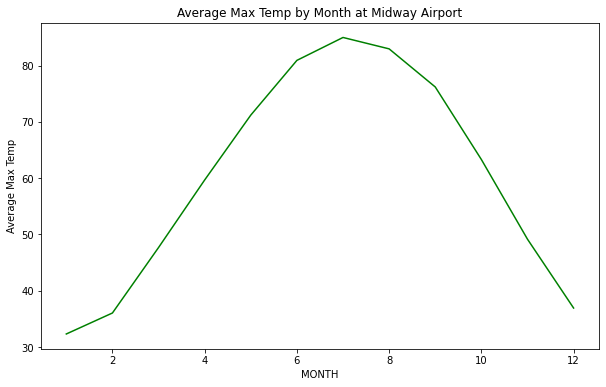

In [59]:
hist.groupby('MONTH')['TMAX'].mean().plot(kind='line', figsize=(10,6), color='green')
plt.ylabel('Average Max Temp')
plt.title('Average Max Temp by Month at Midway Airport')


In [60]:
hist['YEAR'] = 0
for i in hist.index:
    hist['YEAR'][i] = hist['DATE'][i].year
hist['YEAR'].value_counts()

<ipython-input-60-2bfa3c30568d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['YEAR'][i] = hist['DATE'][i].year


1988    366
2020    366
1992    366
2000    366
2008    366
2016    366
1996    366
2004    366
2012    366
1984    366
1995    365
2021    365
1999    365
1991    365
1983    365
1985    365
1993    365
2001    365
2009    365
2017    365
1986    365
1994    365
2002    365
2010    365
2018    365
1987    365
2015    365
2003    365
2011    365
2019    365
2007    365
2014    365
2006    365
1998    365
1990    365
1981    365
1989    365
1997    365
2005    365
2013    365
1982    364
2022    307
1980    306
Name: YEAR, dtype: int64

In [61]:
type(hist['MONTH'][0])
hist['MONTH'] = hist['MONTH'].astype('category')
type(hist['MONTH'][0])

numpy.int64

### Three Day Rolling Average (High)

In [62]:
# intializing the values that will not be caputured by the rolling mean
hist["three_day"] = hist["TMAX"].rolling(3).mean()
hist['three_day']
hist['three_day'][1] = (hist["TMAX"][0] + hist["TMAX"][1]) / 2
hist['three_day'][0] = hist["TMAX"][0]


<ipython-input-62-55b8716960ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['three_day'][1] = (hist["TMAX"][0] + hist["TMAX"][1]) / 2
<ipython-input-62-55b8716960ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['three_day'][0] = hist["TMAX"][0]


### Seven Day Rolling Average (High)

In [63]:
hist["seven_day"] = hist["TMAX"].rolling(7).mean()

In [64]:
sum(hist["seven_day"].isnull())

80

In [65]:
# intializing the values that will not be caputured by the rolling mean
hist['seven_day'][0] = hist["TMAX"][0]
hist['seven_day'][1] = (hist["TMAX"][0] + hist["TMAX"][1]) / 2
hist['seven_day'][2] = (hist["TMAX"][0] + hist["TMAX"][1] + hist["TMAX"][2]) / 3
hist["seven_day"][3] = (hist["TMAX"][0] + hist["TMAX"][1] + hist["TMAX"][2] + hist["TMAX"][3]) / 4
hist["seven_day"][5] = (hist["TMAX"][0] + hist["TMAX"][1] + hist["TMAX"][2] + hist["TMAX"][3] + hist["TMAX"][5]) / 5
hist["seven_day"][7] = (hist["TMAX"][0] + hist["TMAX"][1] + hist["TMAX"][2] + hist["TMAX"][3] + hist["TMAX"][7]) / 6

<ipython-input-65-8f27b69c3ce7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['seven_day'][0] = hist["TMAX"][0]
<ipython-input-65-8f27b69c3ce7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['seven_day'][1] = (hist["TMAX"][0] + hist["TMAX"][1]) / 2
<ipython-input-65-8f27b69c3ce7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['seven_day'][2] = (hist["TMAX"][0] + hist["TMAX"][1] + hist["TMAX"][2]) / 3
<ipython-inpu

Text(0.5, 1.02, 'Correlation of Historical Weather Variables')

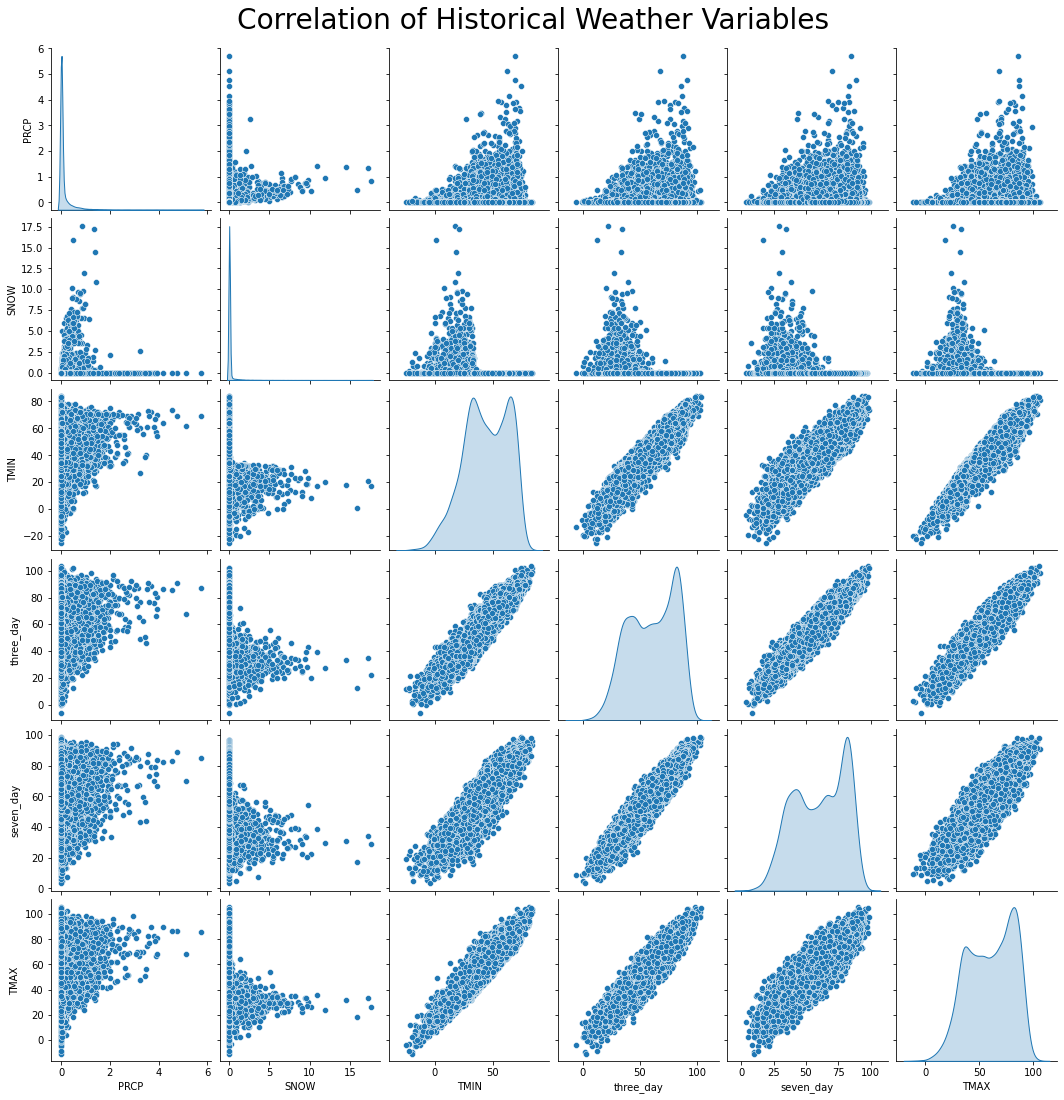

In [66]:
# creating a pairplot
import seaborn as sns
sns.pairplot(hist[['PRCP','SNOW','TMIN','MONTH','three_day','seven_day','TMAX']], diag_kind='kde')
# title
plt.suptitle('Correlation of Historical Weather Variables', fontsize=28, y = 1.02)


In [67]:
# making month categorical
hist['MONTH'] = hist['MONTH'].astype('category')
# one hot encoding month
hist = pd.get_dummies(hist, columns=['MONTH'], prefix = ['month'])

In [68]:
hist.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TMAX,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1980-01-01,0.00,0.0,0.0,45.0,...,0,0,0,0,0,0,0,0,0,0
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1980-01-02,0.00,0.0,0.0,30.0,...,0,0,0,0,0,0,0,0,0,0
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1980-01-03,0.00,0.0,0.0,34.0,...,0,0,0,0,0,0,0,0,0,0
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1980-01-04,0.00,0.0,0.0,31.0,...,0,0,0,0,0,0,0,0,0,0
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",41.7372,-87.7775,189,1980-01-05,0.02,NaN,0.0,29.0,...,0,0,0,0,0,0,0,0,0,0


The code below creates the modeling dataset which removes columns that we found to have the same value (station, lattitude, etc.) and columns that we found to have almost all of the values missing (WT05, WT06, etc.). 

In [69]:
final_df = hist.loc[:,['PRCP','SNOW','TMIN','month_1','month_2','month_3','month_4','month_5','month_6','month_7',
'month_8','month_9','month_10','month_11','month_12','three_day','seven_day','TMAX']]

In [70]:
final_df.columns

Index(['PRCP', 'SNOW', 'TMIN', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'three_day', 'seven_day', 'TMAX'],
      dtype='object')

In [71]:
final_df.head()
final_df.shape

(15587, 18)

In [78]:
# dropping values with NA values before modeling
final_df.dropna(inplace=True)
final_df.shape

(15365, 18)

## Importing Modeling / Data Split Libraries

In [79]:
# splits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# metrics
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

## Train/Test Cross Validation Splits

In [80]:
# Create the KFold object with 10 splits
kf = KFold(n_splits=10)

## Linear Model (All Variables)

In [81]:
mse_values = []

# Loop through the splits
for train_index, test_index in kf.split(final_df):
  train_df, test_df = final_df.iloc[train_index], final_df.iloc[test_index]

  # Create the linear regression model
  lr = LinearRegression()

  # Fitting model
  lr.fit(train_df.drop(columns=['TMAX']), train_df['TMAX'])

  # Test data predictions
  predictions = lr.predict(test_df.drop(columns=['TMAX']))

  # Calculate MSE, appending
  mse = mean_squared_error(test_df['TMAX'], predictions)
  mse_values.append(mse)


mean_mse = np.mean(mse_values)
print(mean_mse)
print(mse_values)

27.982071529707078
[30.921111382582595, 31.62439622332474, 28.98728351752956, 28.176278439017416, 26.280994642254946, 25.977851629237406, 25.984794391737267, 27.728328780260266, 25.49673416708859, 28.64294212403802]


In [82]:
# RMSE
mean_mse ** (.5)

5.289808269654683

## Trying another linear model
Seven day, three day, and TMIN are highly correlated. This likely isn't optimal.

However, I tried some combination of these below (some since deleted) and they don't out perform the model with all variables.

In [83]:
lr_df = final_df.loc[:,['PRCP','SNOW','TMIN','month_1','month_2','month_3','month_4','month_5','month_6','month_7',
'month_8','month_9','month_10','month_11','month_12','three_day','TMAX']]

In [84]:
mse_values = []

for train_index, test_index in kf.split(lr_df):
  train_df, test_df = lr_df.iloc[train_index], lr_df.iloc[test_index]

  # Model
  lr2 = LinearRegression()

  # Fit model
  lr2.fit(train_df.drop(columns=['TMAX']), train_df['TMAX'])

  # Test preds
  predictions = lr2.predict(test_df.drop(columns=['TMAX']))

  # add to list
  mse = mean_squared_error(test_df['TMAX'], predictions)
  mse_values.append(mse)

# Calculat
mean_mse = np.mean(mse_values)
print(mean_mse)
print(mse_values)

28.8486729831778
[31.93980887636235, 32.21432961409436, 30.154925652096953, 29.189952055861486, 26.81627413692092, 26.866683182096622, 26.977385140386644, 28.539010610098103, 26.28164312390599, 29.50671743995457]


In [85]:
mean_mse ** (1/2)

5.371096069069869

## KNN

In [87]:
# specify the values of the k and distance metric parameters that you want to test
k_values = []
for i in range(1,100,2):
    k_values.append(i)
rmses = []
temp = []

# loop over the folds and the parameter values
for k in k_values:
    for train_index, test_index in kf.split(final_df):
        # data sets
        X_train = final_df.drop('TMAX', axis=1).iloc[train_index]
        X_test = final_df.drop('TMAX', axis=1).iloc[test_index]
        y_train = final_df['TMAX'].iloc[train_index]
        y_test = final_df['TMAX'].iloc[test_index]
        
        # train KNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # predict
        y_pred = knn.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        temp.append(rmse)
    rmses.append([k, sum(temp)/len(temp)])
    temp = []




In [88]:
rmses

[[1, 7.406475130226966],
 [3, 6.01822068283137],
 [5, 5.729239718211829],
 [7, 5.592270088914997],
 [9, 5.51480278037417],
 [11, 5.465540751533],
 [13, 5.435129887964945],
 [15, 5.412132153394584],
 [17, 5.395841191852698],
 [19, 5.382495495668092],
 [21, 5.3751103339648125],
 [23, 5.367342931109383],
 [25, 5.3612655689342805],
 [27, 5.351264815176681],
 [29, 5.344217854006541],
 [31, 5.343475651727983],
 [33, 5.340984653756465],
 [35, 5.337532133347738],
 [37, 5.332119429251529],
 [39, 5.330992053985544],
 [41, 5.330151081381597],
 [43, 5.330931835158276],
 [45, 5.333811186779701],
 [47, 5.334091590467314],
 [49, 5.335422361247284],
 [51, 5.3350604525599525],
 [53, 5.33472109540863],
 [55, 5.33560650520614],
 [57, 5.335137238591167],
 [59, 5.334947515002892],
 [61, 5.336809099283875],
 [63, 5.340476319893441],
 [65, 5.340374820307308],
 [67, 5.3411449304479675],
 [69, 5.341362538406289],
 [71, 5.3419945344033355],
 [73, 5.343229131144927],
 [75, 5.344171410736044],
 [77, 5.34560666343

Text(0.5, 1.0, 'RMSE vs. k')

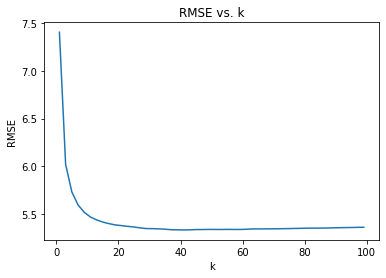

In [89]:
knn_rmse = pd.DataFrame(rmses, columns=['k', 'rmse'])
knn_rmse

plt.plot(knn_rmse['k'], knn_rmse['rmse'])
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('RMSE vs. k')

In [90]:
knn_rmse[knn_rmse['rmse'] == knn_rmse['rmse'].min()]

,k,rmse
20,41,5.330151


## Random Forest

In [91]:
num_trees = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
temp_rf = []
rmses_rf = []

for n in num_trees:
    for max_depth in max_depths:
        for train_index, test_index in kf.split(final_df):
            # splitting data
            X_train = final_df.drop('TMAX', axis=1).iloc[train_index]
            X_test = final_df.drop('TMAX', axis=1).iloc[test_index]
            y_train = final_df['TMAX'].iloc[train_index]
            y_test = final_df['TMAX'].iloc[test_index]
            
            # train / fit
            rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth)
            rf.fit(X_train, y_train)
            
            # preds
            y_pred = rf.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            temp_rf.append(rmse)

        rmses_rf.append([n,max_depth, sum(temp_rf)/len(temp_rf)])
        temp_rf = []


In [93]:
rf_rmse = pd.DataFrame(rmses_rf, columns=['NumTrees','MaxDepth','rmse'])
rf_rmse

,NumTrees,MaxDepth,rmse
0,5,1,11.320666
1,5,2,7.695185
2,5,3,6.292955
3,5,4,5.725005
4,5,5,5.510449
...,...,...,...
195,50,16,5.358276
196,50,17,5.380220
197,50,18,5.392264
198,50,19,5.396127


In [94]:
rf_rmse[rf_rmse['rmse'] == rf_rmse['rmse'].min()]

,NumTrees,MaxDepth,rmse
168,45,9,5.202332


In summary, the random forest was the best performing method with an RMSE of 5.20, followed by the linear regression with and RMSE of 5.28, and finally by the K nearest neighbors approach that had an RMSE of 5.33